<a href="https://colab.research.google.com/github/jeonghojo00/MovieSceneSegmentation/blob/main/SceneSegmentationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import glob
import json
import pickle
import pandas as pd
import collections

import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization, Concatenate, Conv1D, Conv2D, MaxPool1D, MaxPool2D 
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import sparse_categorical_crossentropy


In [ ]:
#pip install git+https://github.com/keras-team/autokeras.git@master
#pip install git+https://github.com/keras-team/keras-tuner.git@master
#pip install tensorflow==2.2.0

# Import dataset and make dictionaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/My Drive/Colab Notebooks/SceneSegmentation/data_dir/"
filenames = glob.glob(os.path.join(data_dir, "tt*.pkl"))
print("# of IMDB IDs:", len(filenames))

# of IMDB IDs: 64


In [ ]:
from sklearn import preprocessing

place_dict = dict()
cast_dict = dict()
action_dict = dict()
audio_dict = dict()
gt_dict = dict()
gtv_dict = dict() # transformed gt_dict {True: 1.0, False:0.0}
pr_dict = dict()
shot_to_end_frame_dict = dict()

for fn in filenames:
    x = pickle.load(open(fn, "rb"))
    place_dict[x["imdb_id"]] = x["place"].numpy()
    cast_dict[x["imdb_id"]] = x["cast"].numpy()
    action_dict[x["imdb_id"]] = x["action"].numpy()
    audio_dict[x["imdb_id"]] = x["audio"].numpy()
    gt_dict[x["imdb_id"]] = x["scene_transition_boundary_ground_truth"].numpy()
    gtData = x["scene_transition_boundary_ground_truth"].numpy()
    gtData = np.where(gtData==True, 1.0, 0.0)
    gtv_dict[x["imdb_id"]] = gtData
    pr_dict[x["imdb_id"]] = x["scene_transition_boundary_prediction"].numpy() 
    shot_to_end_frame_dict[x["imdb_id"]] = x["shot_end_frame"].numpy()

In [ ]:
'''
Calculate a maximum number of shots among movies
Input: dataset : Dictionary
Output: maximum number of shots(rows) of movies : Int
'''
def max_shot_num(data):
    max_num = 0
    for movie in data.keys():
        if max_num < len(data[movie]):
            max_num = len(data[movie])
    
    return max_num

# Make Train and Test sets

In [ ]:
def split_train_test_input(data, ratio=0.8):
    numMovies = len(data)
    numTrain = round(numMovies*ratio)
    numMaxShots = max_shot_num(data)
    numDims = len(data[str(list(data.keys())[0])][0])
        
    count = 0

    for movie in data.keys():
        if len(data[movie]) < numMaxShots:
            dim_empty_rows = (1, numMaxShots-len(data[movie]), numDims)
            empty_rows = np.zeros(dim_empty_rows)
            if count == 0:
                dataBase = np.array(data[movie], ndmin=3)
                dataBase = np.concatenate((dataBase, empty_rows), axis=1)
            else:
                addData = np.array(data[movie], ndmin=3)
                addData = np.concatenate((addData, empty_rows), axis=1)
                dataBase = np.concatenate((dataBase, addData))
        else:
            if count == 0:
                dataBase = np.array(data[movie], ndmin=3)
            else:
                addData = np.array(data[movie], ndmin=3)
                dataBase = np.concatenate((dataBase, addData))
        count += 1
        
    trainDataBase = dataBase[:numTrain,:,:]
    testDataBase = dataBase[numTrain:,:,:]
    
    return trainDataBase, testDataBase
    
     

In [ ]:
placeTrain, placeTest = split_train_test_input(place_dict)
castTrain, castTest = split_train_test_input(cast_dict)
actionTrain, actionTest = split_train_test_input(action_dict)
audioTrain, audioTest = split_train_test_input(audio_dict)

In [ ]:
def split_train_test_output(data, ratio=0.8):
    numMovies = len(data)
    numTrain = round(numMovies*ratio)
    numMaxShots = max_shot_num(data)+1
    numDims = 1
        
    count = 0

    for movie in data.keys():
        if len(data[movie]) < numMaxShots:
            dim_empty_rows = (1, numMaxShots-len(data[movie]))
            empty_rows = np.zeros(dim_empty_rows)
            if count == 0:
                dataBase = np.array(data[movie], ndmin=2)
                dataBase = np.concatenate((dataBase, empty_rows), axis=1)
            else:
                addData = np.array(data[movie], ndmin=2)
                addData = np.concatenate((addData, empty_rows), axis=1)
                dataBase = np.concatenate((dataBase, addData))
        else:
            if count == 0:
                dataBase = np.array(data[movie], ndmin=2)
            else:
                addData = np.array(data[movie], ndmin=2)
                dataBase = np.concatenate((dataBase, addData))
        count += 1
        
    trainDataBase = dataBase[:numTrain]
    testDataBase = dataBase[numTrain:]
    
    return trainDataBase, testDataBase
    

In [ ]:
gtTrain, gtTest = split_train_test_output(gtv_dict)
prTrain, prTest = split_train_test_output(pr_dict)

# Scene Segmentation model

In [ ]:
def ssmodel(input1, input2, input3, input4):
    kernel_size = 4

    cnn1 = Sequential()
    cnn1.add(Conv1D(512, kernel_size=kernel_size, padding='same', activation='relu' ,input_shape=input1[1:]))
    cnn1.add(BatchNormalization())
    cnn1.add(Conv1D(128, kernel_size=kernel_size, padding='same', activation='relu'))
    cnn1.add(BatchNormalization())
    cnn1.add(Conv1D(32, kernel_size=kernel_size, padding='same', activation='relu'))
    cnn1.add(BatchNormalization())
    cnn1.add(Conv1D(1, kernel_size=kernel_size, padding='same', activation='relu'))
    cnn1.add(BatchNormalization())

    cnn2 = Sequential()
    cnn2.add(Conv1D(128, kernel_size=kernel_size, padding='same', activation='relu' ,input_shape=input2[1:]))
    cnn2.add(BatchNormalization())
    cnn2.add(Conv1D(32, kernel_size=kernel_size, padding='same', activation='relu'))
    cnn2.add(BatchNormalization())
    cnn2.add(Conv1D(1, kernel_size=kernel_size, padding='same', activation='relu'))
    cnn2.add(BatchNormalization())

    cnn3 = Sequential()
    cnn3.add(Conv1D(128, kernel_size=kernel_size, padding='same', activation='relu' ,input_shape=input3[1:]))
    cnn3.add(BatchNormalization())
    cnn3.add(Conv1D(32, kernel_size=kernel_size, padding='same', activation='relu'))
    cnn3.add(BatchNormalization())
    cnn3.add(Conv1D(1, kernel_size=kernel_size, padding='same', activation='relu'))
    cnn3.add(BatchNormalization())

    cnn4 = Sequential()
    cnn4.add(Conv1D(128, kernel_size=kernel_size, padding='same', activation='relu' ,input_shape=input4[1:]))
    cnn4.add(BatchNormalization())
    cnn4.add(Conv1D(32, kernel_size=kernel_size, padding='same', activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Conv1D(1, kernel_size=kernel_size, padding='same', activation='relu'))
    cnn4.add(BatchNormalization())


    merged = Concatenate()([cnn1.output, cnn2.output, cnn3.output, cnn4.output])
    merged = TimeDistributed(Dense(4))(merged)
    merged = Bidirectional(LSTM(4, return_sequences=True))(merged)
    merged = Dense(1, activation='sigmoid')(merged)

    model = Model(
        inputs=[
            cnn1.input, 
            cnn2.input, 
            cnn3.input, 
            cnn4.input
        ], 
        outputs=merged
    
    )
    tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)
    model.compile(loss='binary_crossentropy', 
                      optimizer=Adam(learning_rate=0.001),
                      metrics=[tf.keras.metrics.BinaryAccuracy()])
    
    return model
    
    
    

# Fit and Predict values

In [ ]:
modelSS = ssmodel(placeTrain.shape, castTrain.shape, actionTrain.shape, audioTrain.shape)

In [ ]:
numPredict = 2

history = modelSS.fit(
    [
        placeTrain,
        castTrain,
        actionTrain,
        audioTrain
    ],
    gtTrain,
    epochs = 100,
    validation_data=(
        [
            placeTest[:-numPredict],
            castTest[:-numPredict],
            actionTest[:-numPredict],
            audioTest[:-numPredict]
        ],
        gtTest[:-numPredict]
    )
)




Epoch 1/100
2/2 [==============================] - 25s 3s/step - loss: 0.6564 - binary_accuracy: 0.6983 - val_loss: 0.5906 - val_binary_accuracy: 0.9354
Epoch 2/100
2/2 [==============================] - 2s 970ms/step - loss: 0.6059 - binary_accuracy: 0.8926 - val_loss: 0.6659 - val_binary_accuracy: 0.8345
Epoch 3/100
2/2 [==============================] - 2s 1s/step - loss: 0.5926 - binary_accuracy: 0.9263 - val_loss: 0.6776 - val_binary_accuracy: 0.8035
Epoch 4/100
2/2 [==============================] - 2s 975ms/step - loss: 0.5827 - binary_accuracy: 0.9365 - val_loss: 0.6717 - val_binary_accuracy: 0.8155
Epoch 5/100
2/2 [==============================] - 2s 1s/step - loss: 0.5738 - binary_accuracy: 0.9479 - val_loss: 0.6583 - val_binary_accuracy: 0.8483
Epoch 6/100
2/2 [==============================] - 2s 998ms/step - loss: 0.5662 - binary_accuracy: 0.9522 - val_loss: 0.6334 - val_binary_accuracy: 0.8879
Epoch 7/100
2/2 [==============================] - 2s 1s/step - loss: 0.5589 -

In [ ]:

prValues = modelSS.predict(
        [
            placeTest[-numPredict:],
            castTest[-numPredict:],
            actionTest[-numPredict:],
            audioTest[-numPredict:]
        ])

# Accuracy and Loss curves

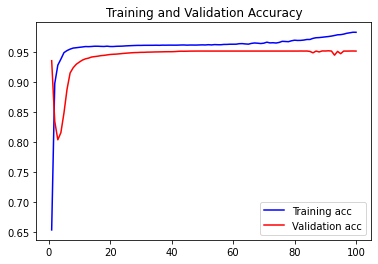

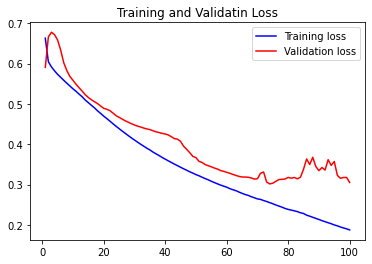

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and Validatin Loss')
plt.legend()
plt.show()

In [ ]:
# Make a list of imdb_id and number of shots for each movie
lstMovie = list()
numShots = list()
for key in gt_dict.keys():
    lstMovie.append(key)
    numShots.append(len(gt_dict[key]))
    
# Make a separate dictionaries for testing predicted value using CNN & Bi-LSTM
prv_dict = dict()
test_gt_dict = dict()
test_shot_to_end_dict = dict()

for i in range(len(prValues)):
    prv_dict[lstMovie[i-numPredict]] = prValues[i][:numShots[i-numPredict]]
    test_gt_dict[lstMovie[i-numPredict]] = gt_dict[lstMovie[i-numPredict]]
    test_shot_to_end_dict[lstMovie[i-numPredict]] = shot_to_end_frame_dict[lstMovie[i-numPredict]]

# Get Scores

In [ ]:
import numpy as np
from sklearn.metrics import average_precision_score


def calc_ap(gt_dict, pr_dict):
    """Average Precision (AP) for scene transitions.

    Args:
        gt_dict: Scene transition ground-truths.
        pr_dict: Scene transition predictions.

    Returns:
        AP, mean AP, and a dict of AP for each movie.
    """
    assert gt_dict.keys() == pr_dict.keys()

    AP_dict = dict()
    gt = list()
    pr = list()
    for imdb_id in gt_dict.keys():
        AP_dict[imdb_id] = average_precision_score(gt_dict[imdb_id], pr_dict[imdb_id])
        gt.append(gt_dict[imdb_id])
        pr.append(pr_dict[imdb_id])

    mAP = sum(AP_dict.values()) / len(AP_dict)

    gt = np.concatenate(gt)
    pr = np.concatenate(pr)
    AP = average_precision_score(gt, pr)

    return AP, mAP, AP_dict


def calc_miou(gt_dict, pr_dict, shot_to_end_frame_dict, threshold=0.5):
    """Maximum IoU (Miou) for scene segmentation.

    Miou measures how well the predicted scenes and ground-truth scenes overlap. The descriptions can be found in
    https://arxiv.org/pdf/1510.08893.pdf. Note the length of intersection or union is measured by the number of frames.

    Args:
        gt_dict: Scene transition ground-truths.
        pr_dict: Scene transition predictions.
        shot_to_end_frame_dict: End frame index for each shot.
        threshold: A threshold to filter the predictions.

    Returns:
        Mean MIoU, and a dict of MIoU for each movie.
    """
    def iou(x, y):
        s0, e0 = x
        s1, e1 = y
        smin, smax = (s0, s1) if s1 > s0 else (s1, s0)
        emin, emax = (e0, e1) if e1 > e0 else (e1, e0)
        return (emin - smax + 1) / (emax - smin + 1)

    def scene_frame_ranges(scene_transitions, shot_to_end_frame):
        end_shots = np.where(scene_transitions)[0]
        scenes = np.zeros((len(end_shots) + 1, 2), dtype=end_shots.dtype)
        scenes[:-1, 1] = shot_to_end_frame[end_shots]
        scenes[-1, 1] = shot_to_end_frame[len(scene_transitions)]
        scenes[1:, 0] = scenes[:-1, 1] + 1
        return scenes

    def miou(gt_array, pr_array, shot_to_end_frame):
        gt_scenes = scene_frame_ranges(gt_array, shot_to_end_frame)
        pr_scenes = scene_frame_ranges(pr_array >= threshold, shot_to_end_frame)
        assert gt_scenes[-1, -1] == pr_scenes[-1, -1]

        m = gt_scenes.shape[0]
        n = pr_scenes.shape[0]

        # IoU for (gt_scene, pr_scene) pairs
        iou_table = np.zeros((m, n))

        j = 0
        for i in range(m):
            # j start prior to i end
            while pr_scenes[j, 0] <= gt_scenes[i, 1]:
                iou_table[i, j] = iou(gt_scenes[i], pr_scenes[j])
                if j < n - 1:
                    j += 1
                else:
                    break
            # j end prior to (i + 1) start
            if pr_scenes[j, 1] < gt_scenes[i, 1] + 1:
                break
            # j start later than (i + 1) start
            if pr_scenes[j, 0] > gt_scenes[i, 1] + 1:
                j -= 1
        assert np.isnan(iou_table).sum() == 0
        assert iou_table.min() >= 0

        # Miou
        return (iou_table.max(axis=0).mean() + iou_table.max(axis=1).mean()) / 2

    assert gt_dict.keys() == pr_dict.keys()

    miou_dict = dict()

    for imdb_id in gt_dict.keys():
        miou_dict[imdb_id] = miou(gt_dict[imdb_id], pr_dict[imdb_id], shot_to_end_frame_dict[imdb_id])
    mean_miou = sum(miou_dict.values()) / len(miou_dict)

    return mean_miou, miou_dict


def calc_precision_recall(gt_dict, pr_dict, threshold=0.5):
    """Precision, Recall and F1 for scene transitions at a given threshold.

    Args:
        gt_dict: Scene transition ground-truths.
        pr_dict: Scene transition predictions.
        threshold: A threshold to filter the predictions.
    Returns:
        Mean Precision, Recall, and F1, per IMDB ID Precisions, Recalls, and F1 scores.
    """
    def precision_recall(gt_array, pr_array):
        tp_fn = gt_array == 1
        tp_fp = pr_array >= threshold

        tps = (tp_fn & tp_fp).sum()

        precision = tps / tp_fp.sum()
        recall = tps / tp_fn.sum()

        return np.nan_to_num(precision), np.nan_to_num(recall)

    assert gt_dict.keys() == pr_dict.keys()

    precision_dict = dict()
    recall_dict = dict()
    fscore_dict = dict()

    for imdb_id in gt_dict.keys():
        p, r = precision_recall(gt_dict[imdb_id], pr_dict[imdb_id])
        precision_dict[imdb_id] = p
        recall_dict[imdb_id] = r
        fscore_dict[imdb_id] = 2 * p * r / (p + r)

    n = len(gt_dict)
    mean_precision = sum(precision_dict.values()) / n
    mean_recall = sum(recall_dict.values()) / n
    mean_fscore = sum(fscore_dict.values()) / n

    return mean_precision, mean_recall, mean_fscore, precision_dict, recall_dict, fscore_dict

In [ ]:
# Get Scores

scores = dict()

scores["AP"], scores["mAP"], _ = calc_ap(test_gt_dict, prv_dict)
scores["Miou"], _ = calc_miou(test_gt_dict, prv_dict, test_shot_to_end_dict)
scores["Precision"], scores["Recall"], scores["F1"], *_ = calc_precision_recall(test_gt_dict, prv_dict)

print("Scores:", json.dumps(scores, indent=4))

Scores: {
    "AP": 0.13857276807671093,
    "mAP": 0.14107670245776366,
    "Miou": 0.04251314979127279,
    "Precision": 0.0,
    "Recall": 0.0,
    "F1": NaN
}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in double_scalars


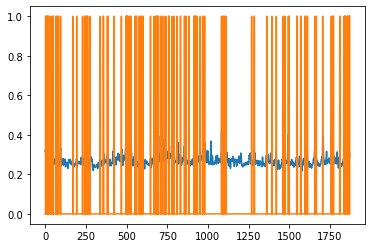

In [ ]:
key = lstMovie[-1]   
plt.plot(prv_dict[key])
plt.plot(test_gt_dict[key])
plt.show()

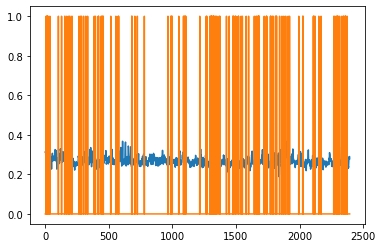

In [ ]:
key = lstMovie[-2]   
plt.plot(prv_dict[key])
plt.plot(test_gt_dict[key])
plt.show()